In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.auto import tqdm
import gpzoo.kernels as kernels
from gpzoo.gp import VNNGP, SVGP
from gpzoo.likelihoods import GaussianLikelihood, NSF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [41]:
def make_data(num_examples, lengthscale, test_prop=0.2):
  kernel = kernel = C(1.0, (1e-3, 1e3)) * RBF(lengthscale, (1e-2, 1e2))
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
  X = np.atleast_2d(np.linspace(-5, 5, num_examples)).T
  Y = gp.sample_y(X, n_samples=1)
  plt.plot(X,Y)
  plt.title("Training Data")
  return X,Y

In [13]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E, verbose=False)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses, gp.Z

### K = 3, Lengthscale 0.1, 1, 10

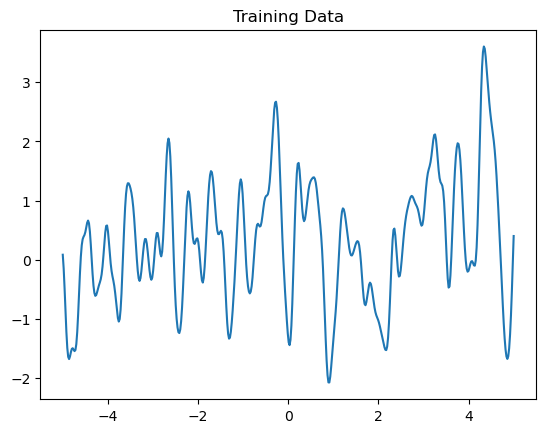

In [52]:
X, y = make_data(500, 0.1)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

In [53]:
M = 1000
k = 3
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

In [55]:
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


In [ ]:
#plt.plot(losses[0])

In [56]:
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()

Text(0.5, 1.0, 'K = 3, Lengthscale = 0.1')

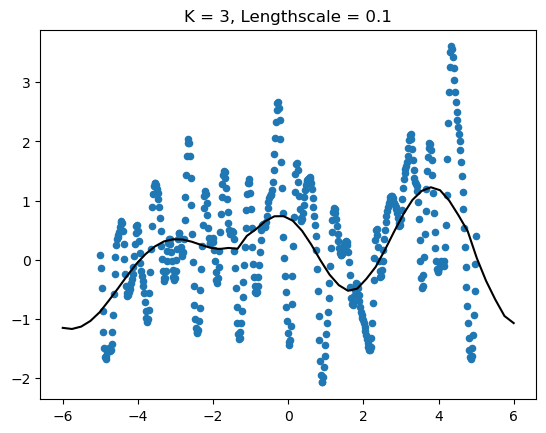

In [57]:
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 3, Lengthscale = 0.1")

Text(0.5, 1.0, 'K = 3, Lengthscale = 0.1')

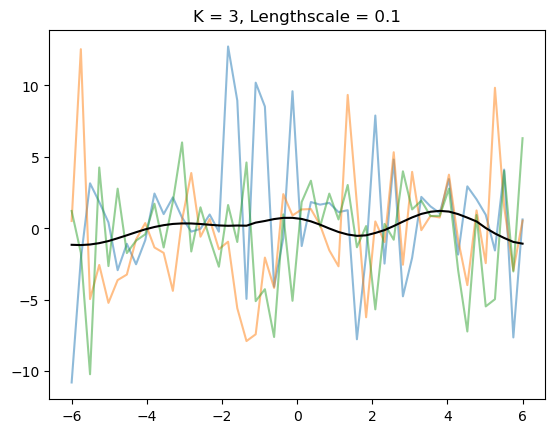

In [58]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 0.1")

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


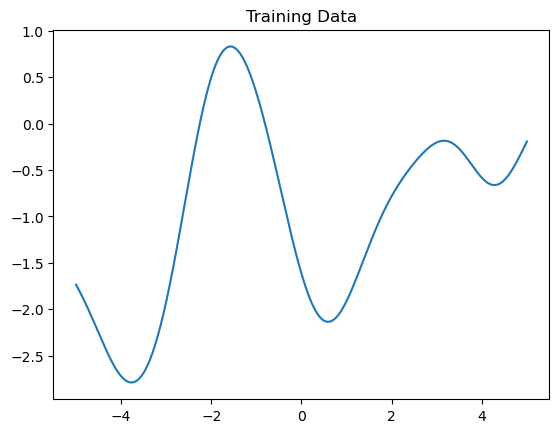

In [42]:
# make data
X, y = make_data(500, 1.0)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

# make model
M = 1000
k = 3
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

# fit model
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

# make test data
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()


Text(0.5, 1.0, 'K = 3, Lengthscale = 1.0')

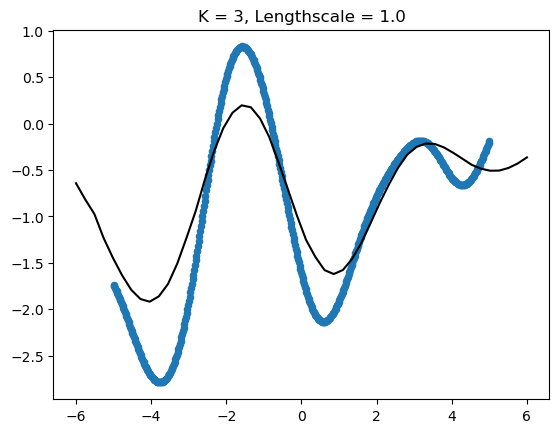

In [43]:
# make plots
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 3, Lengthscale = 1.0")

Text(0.5, 1.0, 'K = 3, Lengthscale = 1.0')

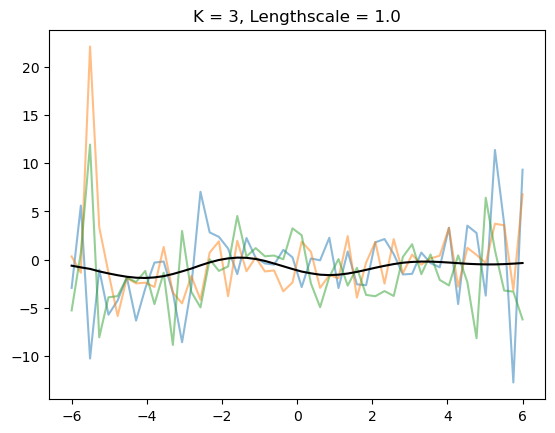

In [45]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 1.0")

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


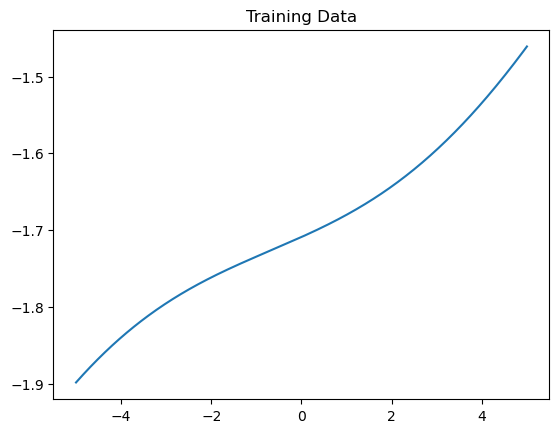

In [46]:
# make data
X, y = make_data(500, 10.0)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

# make model
M = 1000
k = 3
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

# fit model
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

# make test data
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()

Text(0.5, 1.0, 'K = 3, Lengthscale = 10.0')

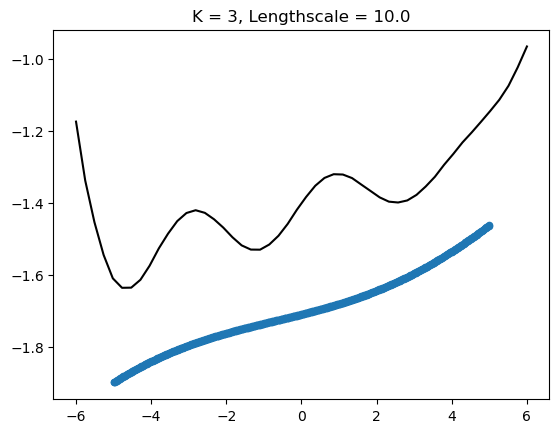

In [49]:
# make plots
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 3, Lengthscale = 10.0")

Text(0.5, 1.0, 'K = 3, Lengthscale = 10.0')

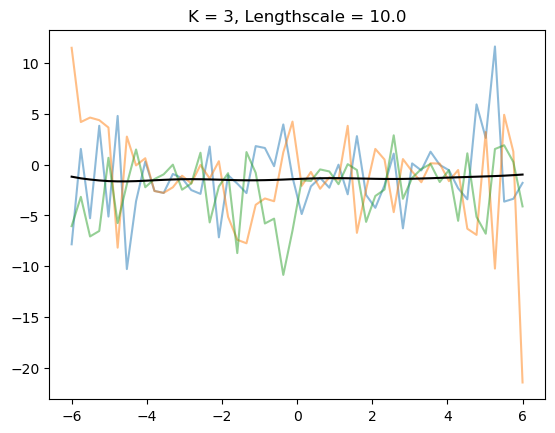

In [50]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 10.0")

### K = 5, Lengthscales 0.1, 1, 10

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


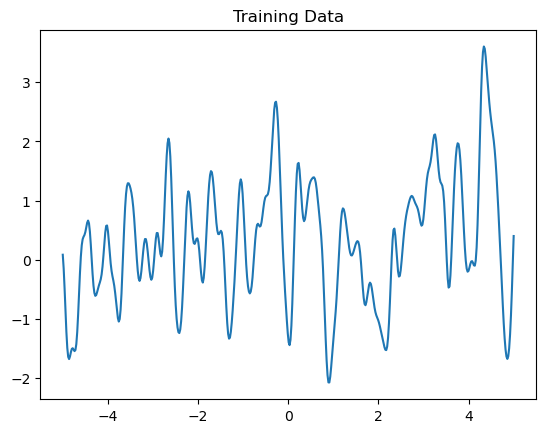

In [124]:
# make data
X, y = make_data(500, 0.1)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

# make model
M = 1000
k = 5
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

# fit model
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

# make test data
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()

Text(0.5, 1.0, 'K = 5, Lengthscale = 0.1')

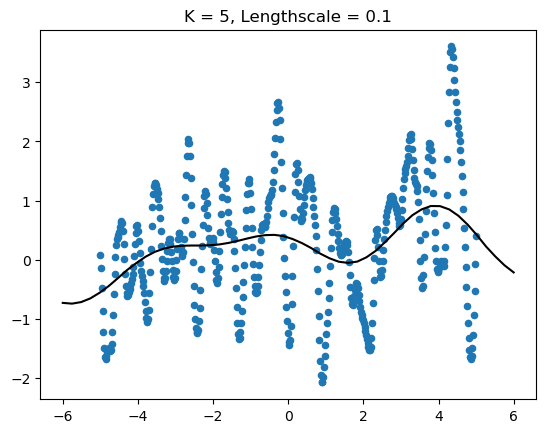

In [125]:
# make plots
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 5, Lengthscale = 0.1")

Text(0.5, 1.0, 'K = 3, Lengthscale = 0.1')

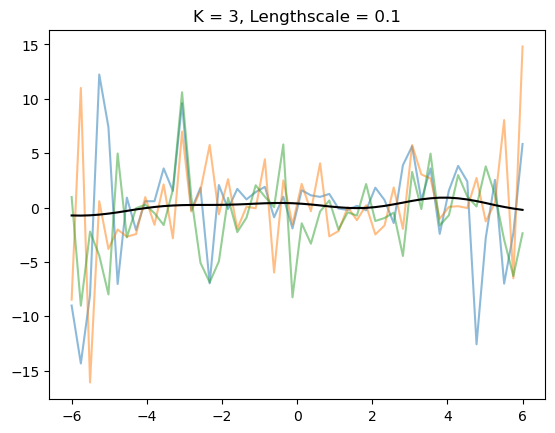

In [126]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 0.1")

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


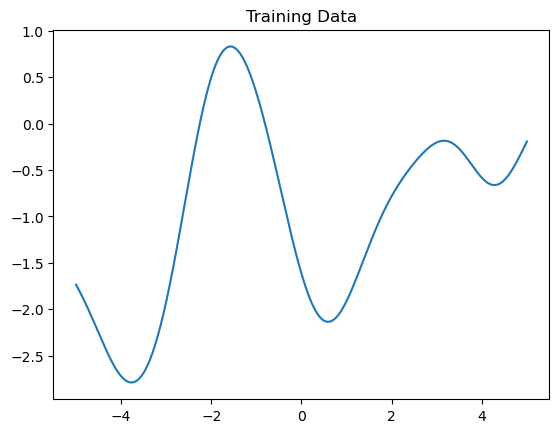

In [127]:
# make data
X, y = make_data(500, 1.0)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

# make model
M = 1000
k = 5
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

# fit model
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

# make test data
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()

Text(0.5, 1.0, 'K = 5, Lengthscale = 0.1')

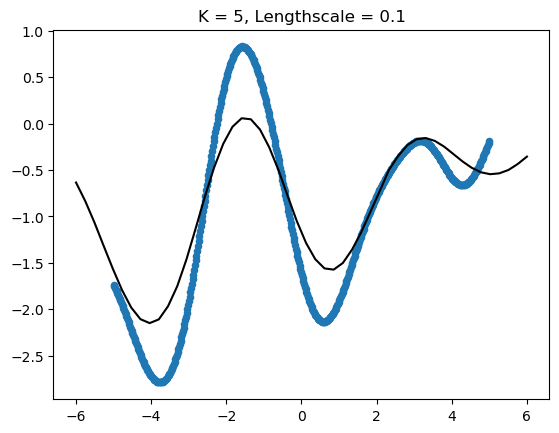

In [128]:
# make plots
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 5, Lengthscale = 0.1")

Text(0.5, 1.0, 'K = 3, Lengthscale = 0.1')

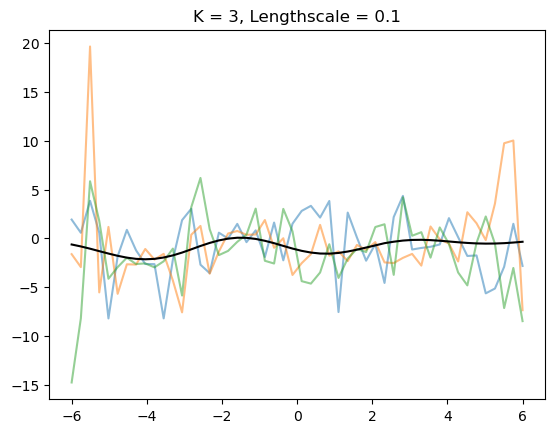

In [129]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 0.1")

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


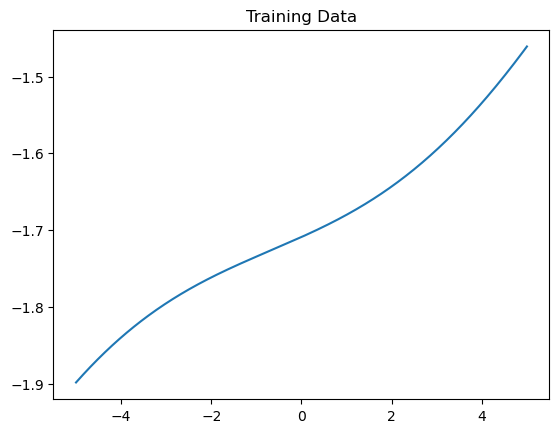

In [130]:
# make data
X, y = make_data(500, 10.0)
X = torch.from_numpy(X)
Y = torch.from_numpy(y)
X = X.float()
Y = Y.float()

# make model
M = 1000
k = 5
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = k
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

# fit model
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

# make test data
X_test = torch.linspace(-6, 6, 50)
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
mean = qF.mean.detach().cpu()

Text(0.5, 1.0, 'K = 5, Lengthscale = 10.0')

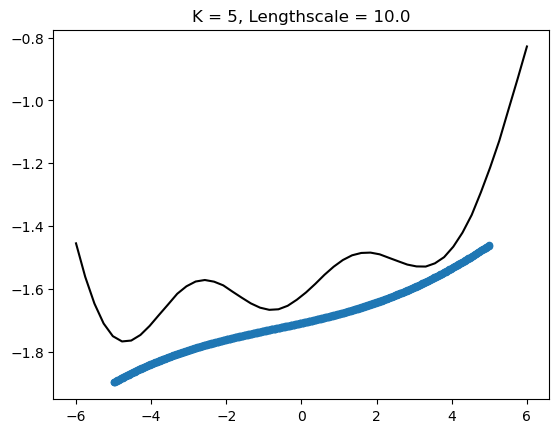

In [131]:
# make plots
plt.plot(X_test, mean, color='black')
plt.scatter(X, y, s=20)
plt.title("K = 5, Lengthscale = 10.0")

Text(0.5, 1.0, 'K = 3, Lengthscale = 10.0')

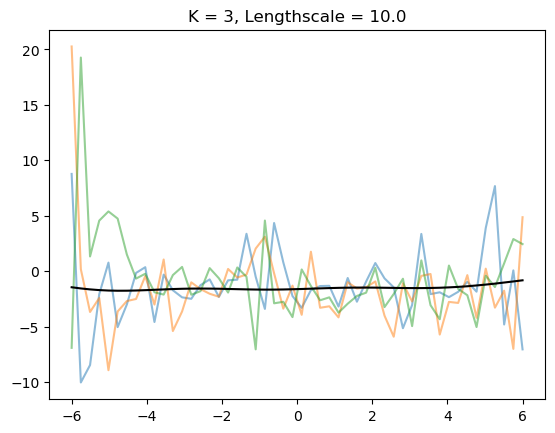

In [132]:
samples = qF.sample((3,))
plt.plot(X_test, samples.detach().cpu().T, alpha=0.5)
plt.plot(X_test, mean, color='black')
plt.title("K = 3, Lengthscale = 10.0")

### k = 5, lengthscale 0.1, 1, 10 concatenated

In [96]:
# Define the kernel function: RBF kernel with length scale of 1.0
lenthscales = [0.1, 1, 10]

kernel = C(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X0 = np.atleast_2d(np.linspace(-5, 5, 100)).T
y_samples = gp.sample_y(X0, n_samples=1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X1 = np.atleast_2d(np.linspace(-5, 5, 100)).T
y1_samples = gp.sample_y(X1, n_samples=1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X2 = np.atleast_2d(np.linspace(-5, 5, 100)).T
y2_samples = gp.sample_y(X2, n_samples=1)


Text(0.5, 1.0, 'Lengthscale 10')

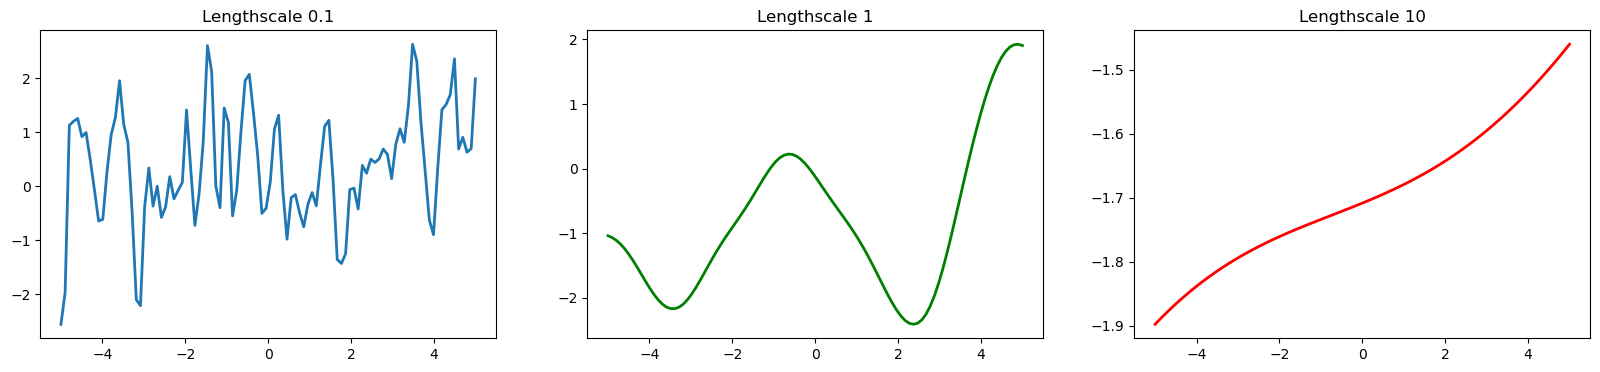

In [97]:
# Data before concatentating
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(1, 3, 1)  # 3 rows, 1 column, first subplot
ax2 = fig.add_subplot(1, 3, 2)  # 3 rows, 1 column, second subplot
ax3 = fig.add_subplot(1, 3, 3)  # 3 rows, 1 column, third subplot


# Plot the sampled functions
ax1.plot(X0, y_samples, lw=2, linestyle='-',)
ax1.set_title('Lengthscale 0.1')

ax2.plot(X1, y1_samples, lw=2, linestyle='-', color="green")
ax2.set_title('Lengthscale 1')

ax3.plot(X2, y2_samples, lw=2, linestyle='-', color="red")
ax3.set_title('Lengthscale 10')

(300, 1)
(300, 1)


Text(0.5, 1.0, 'Concaenated')

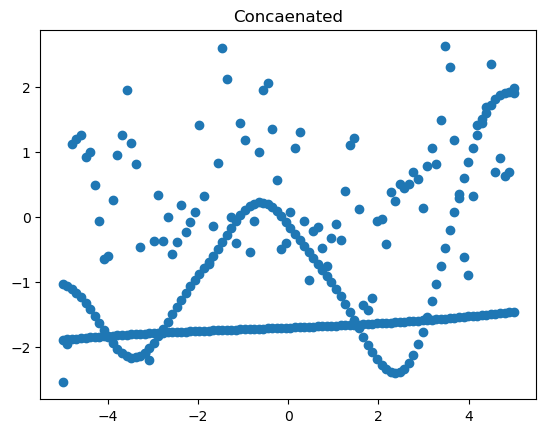

In [98]:
#After concatenating
X = np.concatenate([X0, X1, X2], axis=0)
Y = np.concatenate([y_samples, y1_samples, y2_samples], axis=0)
X_groups = torch.concatenate([torch.zeros(X0.shape[0]), torch.ones(X1.shape[0]), torch.full((X2.shape[0],), 2)]).type(torch.LongTensor)
print(X.shape)
print(Y.shape)
plt.scatter(X, Y)
plt.title('Concaenated')


In [99]:
M = 1000
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)
model.gp.K = 5

In [100]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

In [101]:
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
print(X.shape)
print(Y.shape)

torch.Size([300, 1])
torch.Size([300, 1])


In [102]:
#X = (X[:, None]).to(device)
#Y = Y.to(device)

In [103]:
print(X.shape)
print(Y.shape)

torch.Size([300, 1])
torch.Size([300, 1])


In [104]:
#X = (X[:, None]).to(device)
#y = Y.to(device)

In [105]:
X = X.float()
Y = Y.float()
losses = fit(model, X, torch.squeeze(Y), optimizer, epochs=500, E=200)

  0%|          | 0/500 [00:00<?, ?it/s]

finished Training


Text(0.5, 1.0, 'Losses')

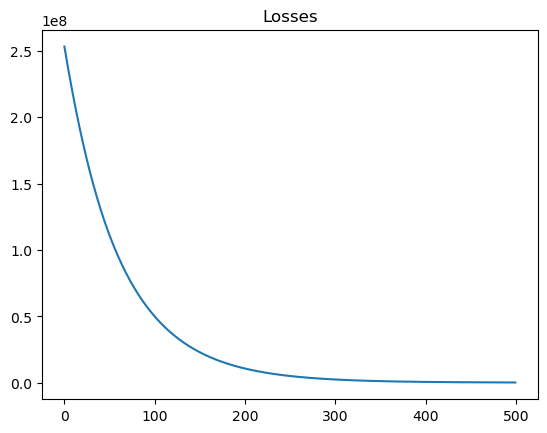

In [106]:
plt.plot(losses[0])
plt.title("Losses")

In [108]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X0 = np.atleast_2d(np.linspace(-5, 5, 200)).T
y_samples = gp.sample_y(X0, n_samples=1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X1 = np.atleast_2d(np.linspace(-5, 5, 200)).T
y1_samples = gp.sample_y(X1, n_samples=1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X2 = np.atleast_2d(np.linspace(-5, 5, 200)).T
y2_samples = gp.sample_y(X2, n_samples=1)

X_test = np.concatenate([X0, X1, X2], axis=0)
Y_test = np.concatenate([y_samples, y1_samples, y2_samples], axis=0)
X_test = torch.from_numpy(X_test)
X_test = X_test.float()
qF, _, _ = model.gp(X_test.to(device), verbose=False)
mean = qF.mean.detach().cpu()

In [111]:
print(mean.shape)

torch.Size([600])


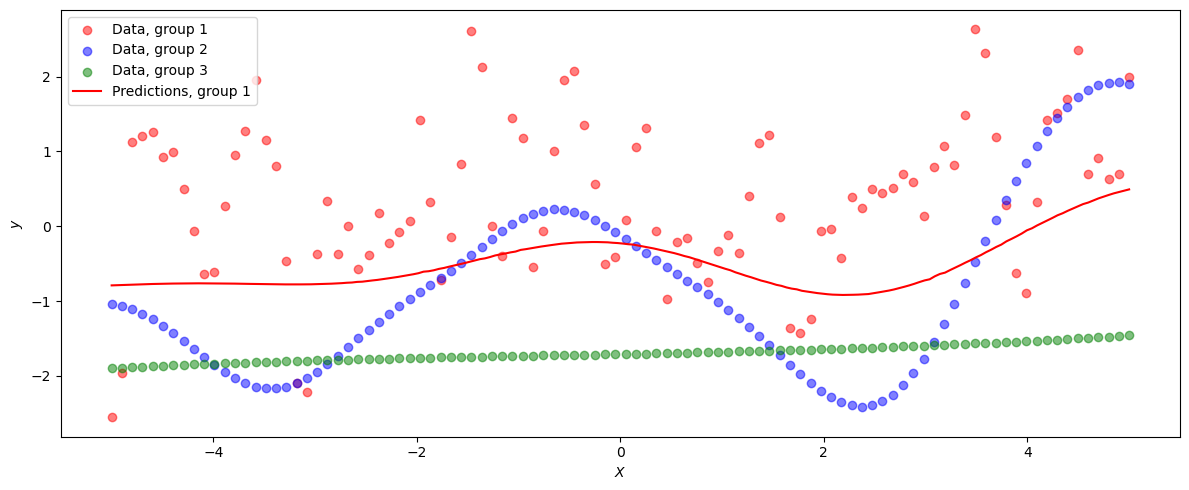

In [114]:
# make plots
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X[:100], Y[:100], color="red", alpha=0.5, label="Data, group 1")
ax.scatter(X[100:200], Y[100:200], color="blue", alpha=0.5, label="Data, group 2")
ax.scatter(X[200:], Y[200:], color="green", alpha=0.5, label="Data, group 3")

ax.plot(X_test[:200], mean[:200], color="red", label="Predictions, group 1")
#ax.plot(X_test[200:400], mean[200:400], color="blue", label="Predictions, group 2")
#ax.plot(X_test[400:], mean[400:], color="green", label="Predictions, group 3")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()

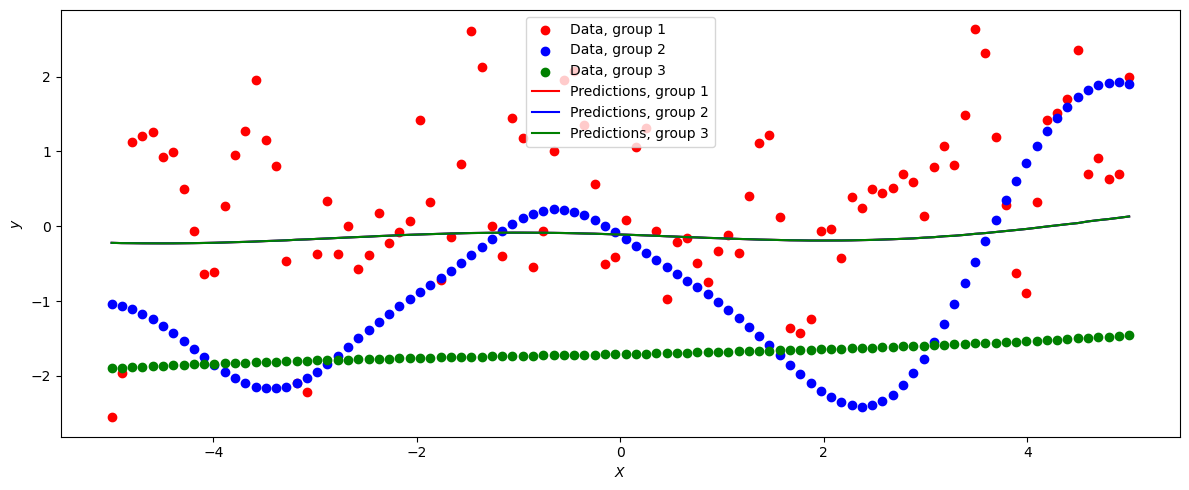

In [69]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X_test[:100], Y_test[:100], color="red", label="Data, group 1")
ax.scatter(X_test[100:200], Y_test[100:200], color="blue", label="Data, group 2")
ax.scatter(X_test[200:], Y_test[200:], color="green", label="Data, group 3")
ax.plot(X_test[:100], mean[:100], color="red", label="Predictions, group 1")
ax.plot(X_test[100:200], mean[100:200], color="blue", label="Predictions, group 2")
ax.plot(X_test[200:], mean[200:], color="green", label="Predictions, group 3")

ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()

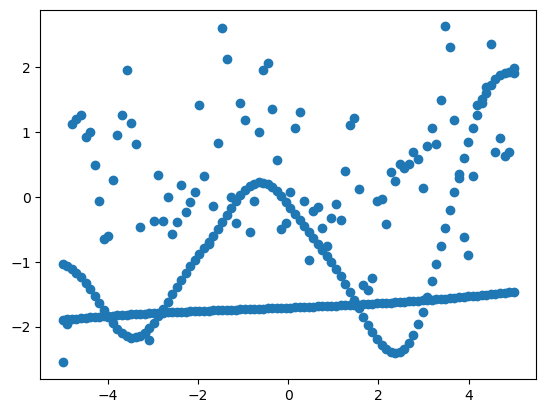

In [71]:
plt.scatter(X_test, Y)

## VNNGP WITH GAUSSIAN LIKLIHOOD

In [92]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [93]:
N = 10000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))
print(X.shape)
print(Y.shape)

torch.Size([10000])
torch.Size([300, 1])


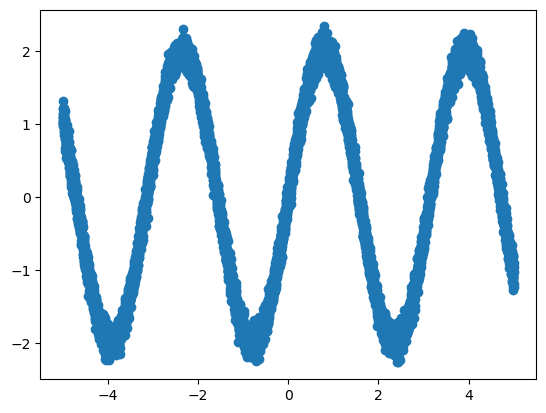

In [94]:
plt.scatter(X, y)


In [95]:
M = 1000
kernel = kernels.RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [96]:
model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): RBF()
  )
)

In [97]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [98]:
print("X_train ", X_train.shape)
print("y_train ", y_train.shape)

X_train  torch.Size([10000, 1])
y_train  torch.Size([10000])


In [99]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E, verbose=True)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses, gp.Z

In [100]:
model.gp.K = 5

In [101]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

In [102]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

  0%|          | 0/100 [00:00<?, ?it/s]

calculating Kxx
Kxx.shape torch.Size([10000, 1])
calculating Kxz
Kxz.shape torch.Size([10000, 1000])
calculating kzz
Kzz.shape torch.Size([1, 1000, 1000])
calculating L
L.shape torch.Size([1, 1000, 1000])
Little_L.shape: torch.Size([1, 10000, 5, 1000])
W_shape: torch.Size([10000, 1, 5])
torch.Size([10000, 1]) torch.Size([10000, 5, 5]) torch.Size([10000, 1, 5]) torch.Size([10000, 5]) torch.Size([10000, 5, 5])
mean.shape: torch.Size([10000, 1, 1])
cov.shape: torch.Size([10000, 1])
calculating Kxx
Kxx.shape torch.Size([10000, 1])
calculating Kxz
Kxz.shape torch.Size([10000, 1000])
calculating kzz
Kzz.shape torch.Size([1, 1000, 1000])
calculating L
L.shape torch.Size([1, 1000, 1000])
Little_L.shape: torch.Size([1, 10000, 5, 1000])
W_shape: torch.Size([10000, 1, 5])
torch.Size([10000, 1]) torch.Size([10000, 5, 5]) torch.Size([10000, 1, 5]) torch.Size([10000, 5]) torch.Size([10000, 5, 5])
mean.shape: torch.Size([10000, 1, 1])
cov.shape: torch.Size([10000, 1])
calculating Kxx
Kxx.shape torch.

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

In [ ]:
X_test = torch.linspace(-12, 12, 10000)

In [ ]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

In [ ]:
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

In [ ]:
M = 1000
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [ ]:
model.to(device)

In [ ]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [ ]:
model.gp.K = 5

In [ ]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [ ]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

In [ ]:
X_test = torch.linspace(-12, 12, 10000)

In [ ]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

## VNNGP WITH NSF

torch.Size([1000])
torch.Size([1000])


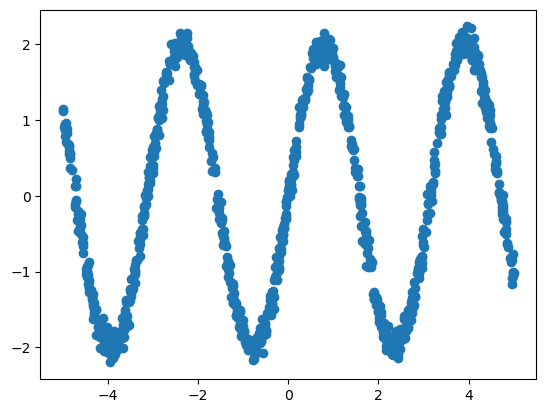

In [ ]:
N = 1000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))
print(X.shape)
print(y.shape)
plt.scatter(X, y)


In [ ]:
# make prototype data of shape (D, N)
# D = number of genes
# N = number of spatial locations
D = 10
y_distribution = distributions.Poisson(torch.rand(D, N) * 10.0)
y = y_distribution.sample()
print(y.shape)

torch.Size([10, 1000])


In [ ]:
M = 100
kernel = NSF_RBF(sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = NSF(gp, y, M=M, L=2)

In [ ]:
model.to(device)

NSF(
  (gp): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [ ]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [ ]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E, verbose=True)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [ ]:
model.gp.K = 5

In [ ]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-2)

In [ ]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=200)

  0%|          | 0/100 [00:00<?, ?it/s]

Kxx.shape before view  torch.Size([10, 1000])
calculating Kxx
Kxx.shape torch.Size([10000, 1])


TypeError: forward() got an unexpected keyword argument 'return_distance'

In [ ]:
#F shape  torch.Size([200, 1, 10000])
#W shape  torch.Size([100, 1])

In [ ]:
%pwd

'/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/GPzoo/notebooks'

In [ ]:
%cd ..

/Users/priyankashrestha/Documents/stanford/research


In [ ]:
%cd data

[Errno 2] No such file or directory: 'data'
/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/data


NameError: name 'sc' is not defined